In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing;
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# %matplotlib inline

In [32]:
import datetime
from datetime import timedelta
forecast_out = 365 #Days from now

stock_ticker ='V'
stock_parameter ='Daily gain'
epoch_number=50
epoch_number_forecast=50

end = datetime.datetime.now()#-timedelta(7) #remove timedetla -1 to go to productions mode
start = datetime.datetime.now()-timedelta(forecast_out)

# benchmark = web.DataReader(stock_ticker, 'yahoo', start, end )
stock = web.DataReader(stock_ticker, 'yahoo', start, end)
stock['Daily gain']=stock['Adj Close'].pct_change(1)
stock=stock.dropna(axis=0)
stock

,High,Low,Open,Close,Volume,Adj Close,Daily gain
Date,,,,,,,
2019-05-07,161.779999,158.679993,160.949997,160.210007,6413600.0,159.235779,-0.012756
2019-05-08,161.699997,159.520004,159.770004,160.759995,5445900.0,159.782410,0.003433
2019-05-09,159.850006,157.169998,158.860001,159.809998,6813700.0,158.838196,-0.005909
2019-05-10,161.399994,157.270004,158.860001,160.710007,5192500.0,159.732727,0.005632
2019-05-13,158.720001,156.419998,157.190002,157.330002,9730000.0,156.373291,-0.021032
...,...,...,...,...,...,...,...
2020-04-27,172.350006,168.550003,168.649994,171.759995,9903300.0,171.759995,0.026536
2020-04-28,175.009995,170.380005,175.000000,171.250000,8614400.0,171.250000,-0.002969
2020-04-29,182.250000,176.100006,176.850006,181.789993,12862800.0,181.789993,0.061547


In [33]:
test_size=20
test_index = len(stock[stock_parameter])- test_size

In [34]:
train = stock[stock_parameter].iloc[:test_index]
test= stock[stock_parameter].iloc[test_index:]

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler=MinMaxScaler()
scaler.fit(train.to_frame())
scaled_train = scaler.transform(train.to_frame())
scaled_test = scaler.transform(test.to_frame())

In [37]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [38]:
length=test_size-1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [40]:
n_features =1
model= Sequential()
# pretty good model at 200 epochs
# model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
# model.add(Dropout(0.2))
# model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='SGD', loss='mse')

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [42]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [43]:
# model.fit_generator(generator, epochs=20,
#                    validation_data=validation_generator, callbacks=[early_stop])
model.fit_generator(generator, epochs=epoch_number,
                   validation_data=validation_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 211 steps, validate for 1 steps
Epoch 1/50
211/211 [==============================] - 3s 16ms/step - loss: 0.0263 - val_loss: 0.0068
Epoch 2/50
211/211 [==============================] - 2s 8ms/step - loss: 0.0130 - val_loss: 0.0050
Epoch 3/50
211/211 [==============================] - 2s 8ms/step - loss: 0.0117 - val_loss: 0.0036
Epoch 4/50
211/211 [==============================] - 2s 8ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 5/50
211/211 [==============================] - 1s 7ms/step - loss: 0.0106 - val_loss: 0.0032
Epoch 6/50
211/211 [==============================] - 1s 7ms/step - loss: 0.0095 - val_loss: 0.0079
Epoch 7/50
211/211 [==============================] - 2s 9ms/step - loss: 0.0091 - val_loss: 7.1717e-04
Epoch 8/50
211/211 [==============================] - 2s 10ms/step - loss: 0.0092 - val_loss: 0.0026
Epoch 9/50
211/211 [======

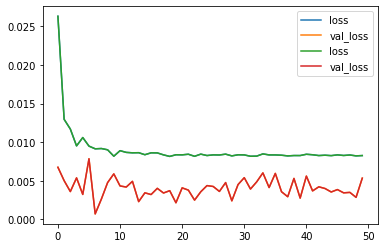

In [44]:
losses= pd.DataFrame(model.history.history)
ax =losses.plot()
losses.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'loss_chart.png')

In [45]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [46]:
true_predictions =scaler.inverse_transform(test_predictions)


In [47]:
predictions = pd.DataFrame(test)
predictions['Predictions'] = true_predictions

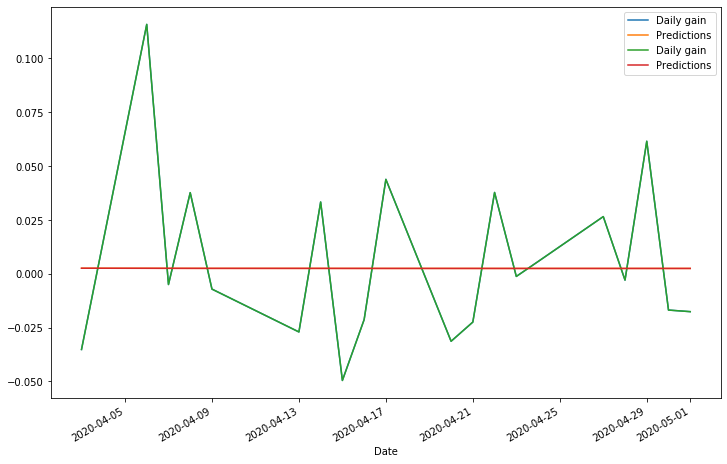

In [48]:
ax=predictions.plot(figsize=(12,8))
predictions.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'_predictions_chart.png')

In [49]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'prediction'+'.h5')

# Forecasting

In [50]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(stock[stock_parameter].to_frame())

In [51]:
length=19
generator=TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [52]:
forecast_model= Sequential()
forecast_model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(50, activation='relu'))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(15, activation='relu'))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(1, activation='relu'))
forecast_model.compile(optimizer='SGD', loss='mse')
forecast_model.fit_generator(generator, epochs=epoch_number_forecast)

  ...
    to  
  ['...']
Train for 231 steps
Epoch 1/50
231/231 [==============================] - 3s 15ms/step - loss: 0.0236
Epoch 2/50
231/231 [==============================] - 2s 8ms/step - loss: 0.0130
Epoch 3/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0108
Epoch 4/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0126
Epoch 5/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0108
Epoch 6/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0102
Epoch 7/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0102
Epoch 8/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0113
Epoch 9/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0104
Epoch 10/50
231/231 [==============================] - 2s 8ms/step - loss: 0.0100
Epoch 11/50
231/231 [==============================] - 2s 7ms/step - loss: 0.0098
Epoch 12/50
231/231 [==============================] - 2s 8ms

In [53]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'forecast'+'.h5')

In [54]:
forecast =[]

periods=19

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [55]:
forecast = scaler.inverse_transform(forecast)

In [56]:
forecast

array([[0.00251392],
       [0.00250383],
       [0.002494  ],
       [0.00248611],
       [0.00247978],
       [0.00247465],
       [0.0024702 ],
       [0.00246646],
       [0.00246344],
       [0.00246011],
       [0.00245795],
       [0.00245629],
       [0.00245462],
       [0.00245351],
       [0.00245278],
       [0.00245229],
       [0.00245194],
       [0.0024515 ],
       [0.00245163]])

In [57]:
from datetime import date
forecast_index = pd.date_range(start=date.today(), periods = periods, freq="D")

In [58]:
forecast_df = pd.DataFrame(data = forecast, index=forecast_index, columns=['Forecast'])

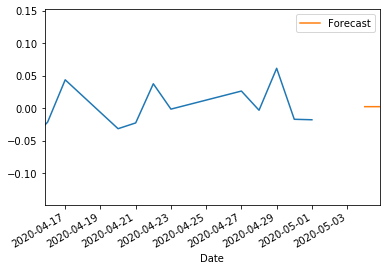

In [59]:
ax=stock[stock_parameter].plot()
forecast_df.plot(ax=ax)
plt.xlim( datetime.datetime.now()-timedelta(periods), datetime.datetime.now())
plt.savefig(stock_ticker+'_'+stock_parameter+'forecast_chart.png')


In [60]:
forecast_df.to_csv('forecast_'+stock_ticker+'_'+stock_parameter+'.csv')